In [1]:
import popoff
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
from average_traces import SingleCells
from scipy import stats
import os
import pickle
import math
from statsmodels.stats import multitest
import copy
import sys
from Session import Session, SessionLite
import seaborn as sns

/home/loidolt/RowlandEtAl/popping-off/popoff/popoff/loadpaths.py
/home/loidolt/RowlandEtAl/Vape


In [3]:
sys.path.append(os.path.expanduser('~/Documents/code'))
plt.rcParams['pdf.fonttype'] = 42

# global plotting params
plt.style.use('ggplot')
# gg plot colors are nice but want seaborn style
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

figure_path = '../figures/mloidolt/'

In [4]:
# global plotting params
sns.set()
sns.set_style('white')
params = {'legend.fontsize': 'xx-large',
          'text.usetex':False,
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

plt.rcParams.update(params)

In [5]:
def load_run(session):
    run_path = os.path.join(session.pkl_path, session.mouse,
                            f'run{session.run_number}.pkl')
    
    with open(run_path, 'rb') as f:
        r = pickle.load(f)
        session.run = r
    return session

In [6]:
single = SingleCells()
# Refactor code here out into this class when need to reuse
sessions = single.sessions
session = sessions[1]

In [7]:
def get_range(session, plot=False):

    if session.mouse == 'RL048' or session.mouse == 'J048':
        # Need to be same length to do wilcoxon
        # Rob does 500ms  so 3 ish frames
        n_frames = 3
        pre_end = 16
        post_start = 30
        
    else:
        # 3 frames above so 15 frames here
        n_frames = 15
        pre_end = 100
        post_start = 160

    pre_range = [pre_end-n_frames, pre_end]
    post_range = [post_start, post_start+n_frames]

    if plot:
        plt.plot(np.mean(session.behaviour_trials, (0,1)))

        for pre, post in zip(post_range, pre_range):
            plt.axvline(pre, color='blue')
            plt.axvline(post, color='red')
    
    return pre_range, post_range

([85, 100], [160, 175])

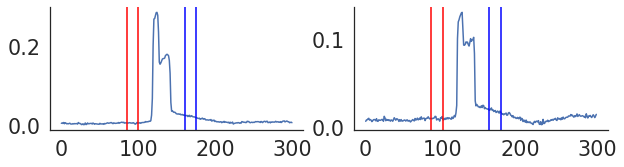

In [8]:
plt.figure(figsize=(10,5))

plt.subplot(2,2,1)
get_range(sessions[2], plot=True)

plt.subplot(2,2,2)

get_range(sessions[0], plot=True)

In [9]:
def prepare_population(arr, frames, mean=True):
    
    arr_frames = arr[:, :, range(*frames)] 
    if mean:
        return np.mean(arr_frames, 2)
    else:
        return np.reshape(arr_frames, (arr_frames.shape[0], arr_frames.shape[1] * arr_frames.shape[2]))

In [10]:
def get_sig_pass(session, fdr_rate=0.1, ps_type=1, subset=[150], outcome='all',
                 cells='all', mask_targets=False, direction='both'):
    
    #arr = session.behaviour_trials[:, session.photostim==ps_type, :]
    
    if mask_targets:
        behaviour_trials = np.ma.array(session.behaviour_trials, mask=session.is_target, copy=True)
    else:
        behaviour_trials = session.behaviour_trials
    
    if len(subset) == 1:
        trials_use = session.trial_subsets == subset[0]
    else:
        trial_bools = [session.trial_subsets==sub for sub in subset]
        trials_use = np.logical_or.reduce(trial_bools)
        
    if outcome != 'all':
        trials_use = np.logical_and(trials_use, session.outcome==outcome)
        
    if outcome =='spont_rew':
        arr = session.pre_rew_trials
    else:
        arr = behaviour_trials[:, trials_use, :]
    
    if cells == 's1':
        arr = arr[session.s1_bool, :, :]
    elif cells == 's2':
        arr = arr[session.s2_bool, :, :]
        
    pre_frames, post_frames = get_range(session, plot=False)

    pre_array = prepare_population(copy.deepcopy(arr), pre_frames)
    post_array = prepare_population(copy.deepcopy(arr), post_frames)
    
    
    if outcome != 'spont_rew' and mask_targets==True:  # This can be made less shit
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)
                 if not pre.mask.all()]
    else:
        p_vals = [stats.wilcoxon(pre, post)[1] for pre, post in zip(pre_array, post_array)]
        
    p_vals = np.array(p_vals)

    sig_cells, correct_pval, _, _ = multitest.multipletests(p_vals, alpha=fdr_rate, method='fdr_bh',
                                                            is_sorted=False, returnsorted=False)
    
    positive = np.mean(post_array, 1) - np.mean(pre_array, 1) > 0
    
    if direction == 'positive':
        sig_cells = np.logical_and(sig_cells, positive)
    elif direction == 'negative': 
        print('why howdy ya;;')
        sig_cells = np.logical_and(sig_cells, ~positive)
    
    return sig_cells

In [11]:
outcomes = ['hit', 'miss', 'fp', 'cr', 'spont_rew']
direction = 'both'

d = {}

    
for region in ['s1', 's2']:
    
    d[region] = {}
    
    for outcome in outcomes:

        outcome_passes = []

        for session in sessions.values():

            if outcome in ['hit', 'miss']:
                subset = [20,30,40,50]
            else:
                subset = [0]

            sig_pass = get_sig_pass(session, subset=subset, outcome=outcome, cells=region, 
                                    mask_targets=True, direction=direction)

            if outcome=='miss':
                print(sum(sig_pass))
            outcome_passes.append(sum(sig_pass) / len(sig_pass) * 100)

        d[region][outcome] = outcome_passes

AttributeError: 'SessionLite' object has no attribute 'is_target'

ValueError: Dimensions of labels and X must be compatible

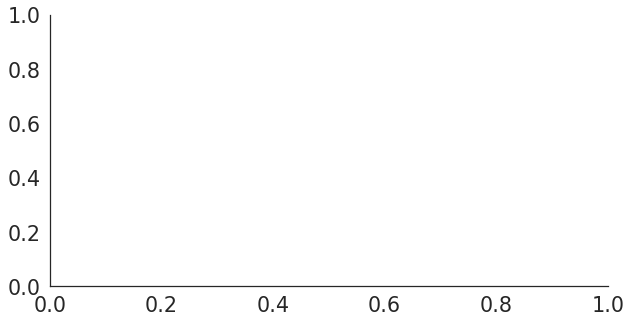

In [12]:
plt.figure(figsize=(10,5))

for idx, region in enumerate(['s1', 's2']):

    if idx == 0:
        labels =  [k for k in d[region].keys()]
    else:
        labels = None
    
    s1s2_offset = 0.3
    tick_positions = np.arange(len(outcomes))*0.8 + idx*s1s2_offset
        
    b_ax = plt.boxplot([v for v in d[region].values()],
                       labels=labels,
                       positions=tick_positions,
                       widths=0.2,
                       patch_artist=True
                       )
    
    plt.xticks(tick_positions-s1s2_offset/2, labels)
    plt.ylabel('Responsive cells (%)')
    
    for element in ['boxes']:
        plt.setp(b_ax[element], color=colors[idx]) 
    
    for element in ['whiskers', 'fliers', 'medians', 'caps']:
        plt.setp(b_ax[element], color='black') 
        
    for patch in b_ax['boxes']:
        patch.set(facecolor=colors[idx])       

    plt.suptitle(direction, fontsize='20')

plt.savefig(os.path.join(figure_path, 'boxey.pdf'), bbox_inches="tight")

In [ ]:
60 * (2/3)

In [ ]:
#### USE ME FOR SANITY CHECKS TO LOOK AT TRIAL AVERAGED CELL TRACES AND SUITE2p IDs
# siggy = get_sig_pass(session, fdr_rate=0.1, ps_type=1, subset=[20,30,40,50], outcome='hit', cells='all')

# s2_siggys = np.logical_and(session.s2_bool, siggy)

# b = session.behaviour_trials

# t_idx = np.logical_and(session.photostim==1, session.outcome=='hit')
# b = b[:, t_idx, :]
# b = b[s2_siggys, :, :]

# # This analysis will only work if no cells have been filtered
# assert len(s2_siggys) == session.behaviour_trials.shape[0] == session.unfiltered_n_cells
# session.load_data()
# assert session.behaviour_trials.shape[0] == session.run.flu.shape[0]

# # The cells that are responsive
# my_bois = np.where(s2_siggys)[0]

# cell = 10
# print(session.run.stat[my_bois[cell]]['original_index'])
# pre_range, post_range = get_range(session)
# plt.plot(np.mean(b[cell, :, :], 0), color='grey', alpha=0.6)

# for pre, post in zip(post_range, pre_range):
#     plt.axvline(pre, color='blue')
#     plt.axvline(post, color='red')

In [ ]:
# for session in sessions.values():
#     if session.n_cells == len(s2_siggys):
#         session.load_data()
#         break
        
# s = session.run.stat[s2_siggys]

# im = np.zeros((514,1024))

# for d in s:
#     im[d['ypix'], d['xpix']] = 1

# plt.imshow(im)

In [71]:
def test_fdr_alpha(session, x_range):
    
    #trial_subsets = [[0], [5,10,20], [30,40,50], [150]]
#     trial_subsets = [[0], [10,20,30,40], [150]]
    trial_subsets = [[0], [20,30,40,50], [150]]
    results = []
    for subset in trial_subsets:
        
        poo = [get_sig_pass(session, fdr_rate, subset=subset) for fdr_rate in x_range]
        results.append(poo)
            
        
    #return np.array(results)
    return np.array(results).swapaxes(2,0).swapaxes(1,2)

In [72]:
def results2percents(results):
    
    percents = np.empty((results.shape[1], results.shape[2]))
    ## TODO vectorise this
    for i in range(results.shape[1]):
        for j in range(results.shape[2]):
            percents[i,j] = sum(results[:,i,j]) / results.shape[0] * 100
            
    return percents

In [73]:
def percent_responding(sessions, return_all=False):
    
    x_range = np.linspace(1e-5, 0.1,  6) 
    
    if return_all:
        raise NotYetImplementedError('Couldnt be bothered to code it if want all cells '
                                     'rather than splitting s1/s2')
    s1 = []
    s2 = []
    
    for idx, session in sessions.items():
        
        results = test_fdr_alpha(session, x_range)
        
        s1_results = results[session.s1_bool, :, :]
        s2_results = results[session.s2_bool, :, :]
        
        s1.append(results2percents(s1_results))
        s2.append(results2percents(s2_results))
    
    # Convert percent lists to arrays and get the axes in the right order
    array_from_list = lambda lst: np.rollaxis(np.array(lst), 0, 3)
    
    return array_from_list(s1), array_from_list(s2)

In [75]:
def plot_percents(percents):
    
    x_range = np.linspace(1e-5, 0.1, 6)  # Make this a function argument / class var
    #trial_subsets = [[0], [5,10,20], [30,40,50], [150]]  # As above
    trial_subsets = [[0], [10,20,30,40], [150]]  # As above
    
    count = 0
    for p, label in zip(percents, trial_subsets):
        count += 1
        mean = np.nanmean(p, 1)
        std = np.nanstd(p, 1) 
        sem = std / len(percents)
        plt.plot(x_range, mean, label=label, color=wes_cols[count])
        plt.fill_between(x_range, mean-std, mean+std, alpha=0.2, color=wes_cols[count])
    plt.xlabel('BH Alpha')
    plt.ylabel('Percentage of cell passing')

NameError: name 's1_percents' is not defined

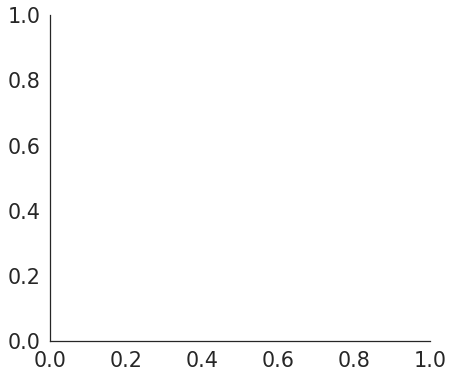

In [76]:
plt.figure(figsize=(15,6))

ax1 = plt.subplot(1,2,1)
#ax1.set_ylim(0,20)
plot_percents(s1_percents)
plt.title("s1")

plt.legend(loc='centre')

ax2 = plt.subplot(1,2,2)
plot_percents(s2_percents)
plt.title("s2")
ax2.set_ylim(ax1.get_ylim())

In [ ]:
x = s1_percents[2, 3, :]

subset = [30,40,50]
n_trials = []


for _, session in sessions.items():
    
    trials_use = np.logical_or(
        np.logical_or(session.trial_subsets==subset[0], session.trial_subsets==subset[1]),
        session.trial_subsets == subset[2]
    )

    n_trials.append(sum(trials_use))
    
plt.plot(x, n_trials, '.')
plt.xlabel('Percentage of cells passing')
plt.ylabel('Number of trials')

In [ ]:
trial_subsets = [[0], [5,10,20], [30,40,50], [150]]

for idx, ts in enumerate(trial_subsets):
    plt.plot(x_range, percent_responding(sessions[0])[idx, :], label=ts)
    
plt.legend()

In [ ]:
x_range = np.linspace(1e-5, 0.1,  6) 

plt.figure(figsize=(25,10))

ax = plt.subplot(1,2,1)


trial_subsets = [[0], [5,10,20], [30,40,50], [150]]
for idx, session in sessions.items():
    
    if len(set(session.trial_subsets)) != 8:
        continue
    if idx == 0:
        results = test_fdr_alpha(session, x_range, 's1')
    else:
        results = np.dstack((results, test_fdr_alpha(session, x_range, 's1')))
        
#for idx, ps_type in enumerate(['nogo', 'test', 'easy']):
for idx, ps_type in enumerate(trial_subsets):
    
    result = results[idx, :, :]
    
    mean = np.mean(result, 1)
    std = np.std(result, 1)
    
    ax.plot(x_range, mean, label=ps_type)
    ax.fill_between(x_range, mean-std, mean+std, alpha=0.2)
    
plt.legend()
    
plt.title('S1')
ax1 = plt.subplot(1,2,2)

for idx, session in sessions.items():
    if len(set(session.trial_subsets)) != 8:
        continue
        
    if idx == 0:
        results = test_fdr_alpha(session, x_range, 's2')
    else:
        results = np.dstack((results, test_fdr_alpha(session, x_range, 's2')))
        
#for idx, ps_type in enumerate(['nogo', 'test', 'easy']):
for idx, ps_type in enumerate(trial_subsets):
        
    result = results[idx, :, :]
    
    mean = np.mean(result, 1)
    std = np.std(result, 1)
    
    ax1.plot(x_range, mean, label=ps_type)
    ax1.fill_between(x_range, mean-std, mean+std, alpha=0.2)
    
ax1.set_ylim(ax.get_ylim())
plt.title('S2')
plt.legend()

ax.set_ylabel('% of cells passing')
for a in [ax, ax1]:
    a.set_xlabel('Benjamini Hochberg Alpha')

In [ ]:
def average_cell_plotter(arr, cell_idx, trials_use, color, label):
    cell  = arr[cell_idx, trials_use, :]
    
    mean = np.mean(cell, 0)
    plt.plot(x_axis, mean, color=color, label=label)
    
    sem = np.std(cell, 0) / math.sqrt(cell.shape[0])
    plt.fill_between(x_axis, mean-sem, mean+sem, color=color)

    plt.legend()

In [ ]:
def compare_prepost(arr, trials_use, cells_use, pre_range, post_range):
    
    if cells_use != 'all':
        arr  = arr[cells_use, :, :]
    if trials_use != 'all':
        arr  = arr[:, trials_use, :]
    pre  = arr[:, :, pre_range[0]:pre_range[1]]
    post = arr[:, :, post_range[0]:post_range[1]]
    
    # Prepost diff for each cell for each trial
    diff = np.mean(post, 2) - np.mean(pre, 2)
    
    # Return prepost differnece for each cell
    return np.mean(diff, 1)

In [ ]:
def hit_tuned(arr, pre_range, post_range):
    
    tuning = (
               compare_prepost(arr, trials_use=session.outcome=='hit', cells_use='all', 
                               pre_range=pre_range, post_range=post_range)
             - compare_prepost(arr, trials_use=session.outcome=='miss', cells_use='all',
                               pre_range=pre_range, post_range=post_range)
             )
    
    return np.flip(np.argsort(tuning))

In [ ]:
for idx, area in enumerate(['s1', 's2']):
    
    hit = []
    miss = []
    pre_rew = []
    
    for _, session in sessions.items():

        arr = session.behaviour_trials
        
        if area == 's1':
            cells_use = session.s1_bool
        elif area == 's2':
            cells_use = session.s2_bool
            
        pre_range, post_range = get_range(session, plot=False)
        
        hit.append(
            compare_prepost(arr, trials_use=session.outcome=='hit', cells_use=cells_use,
                            pre_range=pre_range, post_range=post_range)
        )
        miss.append(
            compare_prepost(arr, trials_use=session.outcome=='miss', cells_use=cells_use,
                            pre_range=pre_range, post_range=post_range)
        )

        ## TODO remove nan trials
        arr = session.pre_rew_trials
        
        pre_rew.append(
            compare_prepost(arr, trials_use=np.repeat(True, arr.shape[1]),
                            cells_use=cells_use, pre_range=pre_range, post_range=post_range)
        )
        
        
    hit = np.concatenate(hit)
    miss = np.concatenate(miss)
    pre_rew = np.concatenate(pre_rew)
    pre_rew = pre_rew[~np.isnan(pre_rew)]
    

    fig = plt.figure(figsize=(16,5))
    fig.subplots_adjust(top=0.75) 
    plt.suptitle(area, fontsize=25)

    n_bins = 30
    xlim = (-0.5, 0.5)
    bins = np.linspace(xlim[0], xlim[1], n_bins)

    ax1 = plt.subplot(1,3,1)
    ax1.set_title(f'Hit skewness = {round(stats.skew(hit), 2)}\nP = {round(stats.skewtest(hit)[1], 2)}')
    h = ax1.hist(hit, bins)

    ax2 = plt.subplot(1,3,2)
    ax2.set_title(f'Miss skewness = {round(stats.skew(miss), 2)}\nP = {round(stats.skewtest(miss)[1], 2)}')
    h = ax2.hist(miss, bins)

    ax3 = plt.subplot(1,3,3)
    ax3.set_title(f'Spont Rew skewness = {round(stats.skew(pre_rew), 2)}\nP = {round(stats.skewtest(pre_rew)[1], 2)}')
    h = ax3.hist(pre_rew, bins)

    for ax in [ax1, ax2, ax3]:
        ax.set_xlabel('dff')
        ax.set_yscale('log')
        ax.set_xlim(xlim)



In [ ]:
def compare_prepost_tbt(arr, pre_range, post_range, cells_use='all', trials_use='all'):
    
    if cells_use != 'all':
        arr  = arr[cells_use, :, :]
    if trials_use != 'all':
        arr  = arr[:, trials_use, :]
    pre  = arr[:, :, pre_range[0]:pre_range[1]]
    post = arr[:, :, post_range[0]:post_range[1]]
    
    mean_pre = np.mean(pre, axis=2)
    std_pre = np.std(pre, axis=2)
    
    mean_post = np.mean(post, axis=2)
    
    
    # commented out if look at excited and inhibited
    #bool_mat = np.logical_or(mean_post > (mean_pre + 2*std_pre), (mean_post < mean_pre - 2*std_pre))
    bool_mat = mean_post > (mean_pre + 2*std_pre)
    p_activated = np.sum(bool_mat, axis=1) / bool_mat.shape[1]
    
    sort_idx = np.flip(np.argsort(np.sum(bool_mat, axis=1)))
    bool_mat = bool_mat[sort_idx, :]
    
    
    return bool_mat, p_activated

In [ ]:
hits = []
misses = []
for _, session in sessions.items():
    #arr = session.behaviour_trials
    arr = np.random.randn(*session.behaviour_trials.shape)
    pre_range, post_range = get_range(session, plot=False)
    
    _, hit = compare_prepost_tbt(arr, pre_range, post_range, 
                                 trials_use=session.outcome=='hit', cells_use=session.s2_bool)
    _, miss = compare_prepost_tbt(arr, pre_range, post_range, 
                                  trials_use=session.outcome=='miss', cells_use=session.s2_bool)
    
    hits.append(hit)
    misses.append(miss)

hits = np.concatenate(hits)
misses = np.concatenate(misses)

In [ ]:
rho, p = stats.spearmanr(hits, misses)
rho

In [ ]:
plt.plot(hits, misses, '.')

In [ ]:
h = plt.hist(hits)
plt.xlabel('P(response)')
plt.yscale('linear')
plt.title('Hit Trials (s2 only)')
plt.xlim(0,0.1)
#plt.ylim(0,100)

In [ ]:
session = sessions[2]
arr = session.behaviour_trials
pre_range, post_range = get_range(session, plot=False)

_, hit = compare_prepost_tbt(arr, pre_range, post_range, trials_use=session.outcome=='hit')
_, miss = compare_prepost_tbt(arr, pre_range, post_range, trials_use=session.outcome=='miss')

plt.figure(figsize=(10,20))
for h, m in zip(hit, miss):
    plt.plot([0,1], [h,m], color='black', marker='o')

plt.xlim(-0.5, 1.5)
plt.ylabel('P(response)')
plt.xticks([0,1], ('Hit', 'Miss'))

In [ ]:
s1, _ = compare_prepost_tbt(arr, trials_use=session.outcome=='hit', cells_use = session.s1_bool, pre_range=pre_range, post_range=post_range)
s2, _ = compare_prepost_tbt(arr, trials_use=session.outcome=='hit', cells_use = session.s2_bool,
                        pre_range=pre_range, post_range=post_range)

In [ ]:
plt.figure(figsize=(8,30))

for idx, area in enumerate([s1, s2]):
    plt.subplot(1,2,idx+1)
    
    plt.title(f's{idx+1}')
    plt.imshow(area)
    plt.ylabel('Cell idx')
    plt.xlabel('Trial Number')

In [ ]:
color_tt = {'hit': 'green', 'miss': 'grey', 'fp': 'magenta', 
            'cr': 'brown', 'ur_hit': '#7b85d4', 'ar_miss': '#e9d043',
            'spont_rew': 'darkorange'}


In [ ]:
session = sessions[2]
session = load_run(session)
    
flu = session.run.flu

arr = session.behaviour_trials
assert flu.shape[0] == arr.shape[0]
x_axis = session.filter_ps_time

if session.mouse == 'RL048' or session.mouse=='J048':
    fs = 5
else:
    fs = 30

In [ ]:
for i in range(3):

    plt.figure()
    
    pre_range, post_range = get_range(session, plot=False)
    
    hit_tuned_idxs = hit_tuned(copy.deepcopy(arr), pre_range, post_range)
    cell_plot = hit_tuned_idxs[i]

    fig = plt.figure(figsize=(16, 6))

    ax1 = fig.add_subplot(2,1,1)
    range_plot = np.arange(0, 15000)
    ax1.plot(range_plot/fs,  flu[cell_plot, range_plot])


    ax2 = fig.add_subplot(2,3,4)

    trial_type = 'hit'
    average_cell_plotter(copy.deepcopy(arr), cell_plot, session.outcome==trial_type, color_tt[trial_type], label=trial_type)
    ax3 = fig.add_subplot(2,3,5)

    trial_type = 'miss'
    average_cell_plotter(copy.deepcopy(arr), cell_plot, session.outcome==trial_type, color_tt[trial_type], label=trial_type)
    ax3.set_ylim(ax2.get_ylim())

    ax4 = fig.add_subplot(2,3,6, frameon=False)
    ax4.text(0.1,0.1, f'{session.mouse}\nrun {session.run_number}\ncell {cell_plot}', fontsize=30)
    ax4.axes.get_yaxis().set_visible(False)
    ax4.axes.get_xaxis().set_visible(False)